In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import sklearn
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import time as t
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cut_tree

In [2]:
%%time
#Visualization of data set
data = pd.read_csv('OnlineRetail.csv', sep=",", header=0, encoding="ISO-8859-1")
data.head()

Wall time: 545 ms


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
#data set description
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [4]:
# Calculating the Missing Values in Data frame

dataframe_null = round(100*(data.isnull().sum())/len(data), 2)
dataframe_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [5]:
# Deleting rows which have missing values

data = data.dropna()

In [6]:
# creating new attribute = Monetary from quantity and unit price

data['Monetary'] = data['Quantity']*data['UnitPrice']
monetary = data.groupby('CustomerID')['Monetary'].sum()
monetary = monetary.reset_index()

In [7]:
# creating new attribute = frequnecy counting customer id and invoices
frequency = data.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'Frequency']

In [8]:
# creating new recency attribute.

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [9]:
# Computing the latest date to know the last transaction date of the customer

latestDate = max(data['InvoiceDate'])
latestDate 

Timestamp('2011-12-09 12:50:00')

In [10]:
# Ccalculating the difference between last date and last transaction date

data['Recency'] = latestDate - data['InvoiceDate']

In [11]:
# Calculating receny by checking last transaction date

recency = data.groupby('CustomerID')['Recency'].min()
recency = recency.reset_index()

In [12]:
# Taking only days

recency['Recency'] = recency['Recency'].dt.days
recency.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [13]:
# merging recency, frequency and monetary as a one data frame.

mergedDateFrame = pd.merge(monetary, frequency, on='CustomerID', how='inner')
mergedDateFrame = pd.merge(mergedDateFrame, recency, on='CustomerID', how='inner')
mergedDateFrame.columns = ['CustomerID', 'Monetary', 'Frequency', 'Recency']
mergedDateFrame.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'RFM Attributes')

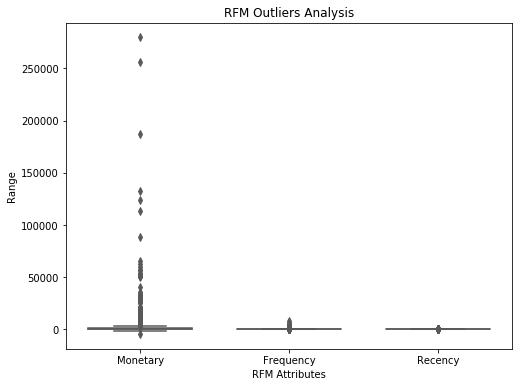

In [14]:
# Analyzing Outliers for RFM.

attributes = ['Monetary','Frequency','Recency']
plt.rcParams['figure.figsize'] = [8,6]
sns.boxplot(data = mergedDateFrame[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("RFM Outliers Analysis", fontsize = 12)
plt.ylabel("Range")
plt.xlabel("RFM Attributes")

In [15]:

# Removing outliers for Recency, frequncy and monetary
Quantile1 = mergedDateFrame.Monetary.quantile(0.05)
Quantile3 = mergedDateFrame.Monetary.quantile(0.95)
InnerQuantileRange = Quantile3 - Quantile1

mergedDateFrame = mergedDateFrame[(mergedDateFrame.Monetary >= Quantile1 - 1.5*InnerQuantileRange) & (mergedDateFrame.Monetary <= Quantile3 + 1.5*InnerQuantileRange)]
Quantile1 = mergedDateFrame.Recency.quantile(0.05)
Quantile3 = mergedDateFrame.Recency.quantile(0.95)
InnerQuantileRange = Quantile3 - Quantile1
mergedDateFrame = mergedDateFrame[(mergedDateFrame.Recency >= Quantile1 - 1.5*InnerQuantileRange) & (mergedDateFrame.Recency <= Quantile3 + 1.5*InnerQuantileRange)]

Quantile1 = mergedDateFrame.Frequency.quantile(0.05)
Quantile3 = mergedDateFrame.Frequency.quantile(0.95)
InnerQuantileRange = Quantile3 - Quantile1
mergedDateFrame = mergedDateFrame[(mergedDateFrame.Frequency >= Quantile1 - 1.5*InnerQuantileRange) & (mergedDateFrame.Frequency <= Quantile3 + 1.5*InnerQuantileRange)]


In [16]:
# Rescaling the merged attributes

merged_DateFrame = mergedDateFrame[['Monetary', 'Frequency', 'Recency']]

scaler = StandardScaler()

merged_DateFrame_scaled = scaler.fit_transform(merged_DateFrame)
merged_DateFrame_scaled.shape

(4293, 3)

In [17]:
# creating new scaled dataframe
merged_DateFrame_scaled = pd.DataFrame(merged_DateFrame_scaled)
merged_DateFrame_scaled.columns = ['Monetary', 'Frequency', 'Recency']
merged_DateFrame_scaled.head()

,Monetary,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


# Implementation of Algorithms

After the vissualliztion and prpartion of data , we re now implementing KMeans alogorithms with randoomly chosen cluster number.

In [19]:
%%time
# implements k-means clustering with some random number of cluster
kmeans_clustering = KMeans(n_clusters=4, max_iter=50)
kmeans_clustering.fit(merged_DateFrame_scaled)

Wall time: 103 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# Evalauting Elbow Curve


Wall time: 707 ms


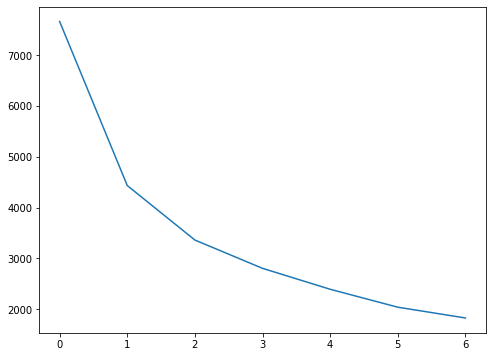

In [21]:
%%time

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(merged_DateFrame_scaled)
    
    ssd.append(kmeans.inertia_)
#plotting eblow curve    
plt.plot(ssd)

# Silhouette analysis 

In [22]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for number_clusters in range_n_clusters:
    
    kmeans = KMeans(n_clusters=number_clusters, max_iter=50)
    kmeans.fit(merged_DateFrame_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(merged_DateFrame_scaled, cluster_labels)
    print("Number_clusters={0}, the silhouette score = {1}".format(number_clusters, silhouette_avg))

Number_clusters=2, the silhouette score = 0.5397106255240607
Number_clusters=3, the silhouette score = 0.5084896296141937
Number_clusters=4, the silhouette score = 0.4817567985759693
Number_clusters=5, the silhouette score = 0.4659634068191317
Number_clusters=6, the silhouette score = 0.4169897163641209
Number_clusters=7, the silhouette score = 0.4158077420309644
Number_clusters=8, the silhouette score = 0.3967718101061674


# K-Means Model with k = 5

In [30]:
%%time 
#we are checking the wall time of the model
kmeans = KMeans(n_clusters=5, max_iter=50)
kmeans.fit(merged_DateFrame_scaled)

Wall time: 98 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [31]:
%%time
# assigning the label to the data frame
mergedDateFrame['Cluster_Id'] = kmeans.labels_
mergedDateFrame.head()

Wall time: 1 ms


,CustomerID,Monetary,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,4
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,0


# Using Box Plot to visualise the plot of monetary vs Cluster_ID

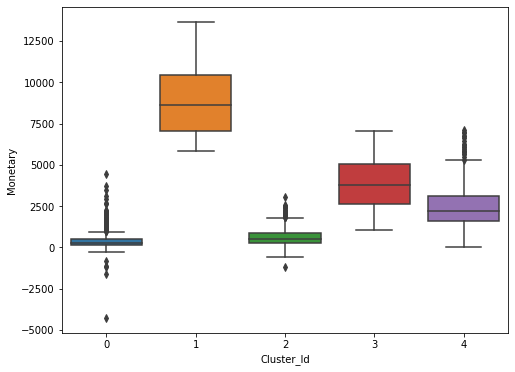

In [32]:
sns.boxplot(x='Cluster_Id', y='Monetary', data=mergedDateFrame)

# Using Box Plot to visualise the plot of Frequency vs Cluster_ID

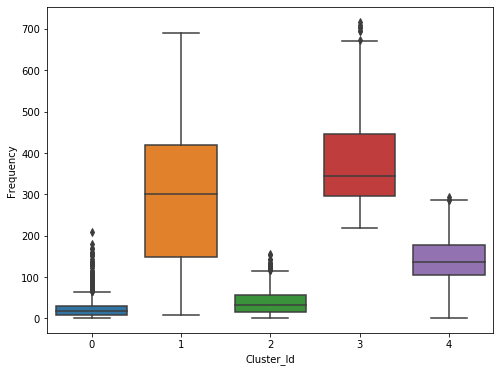

In [33]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=mergedDateFrame)

# Using Box Plot to visualise the plot of Recency vs Cluster_ID

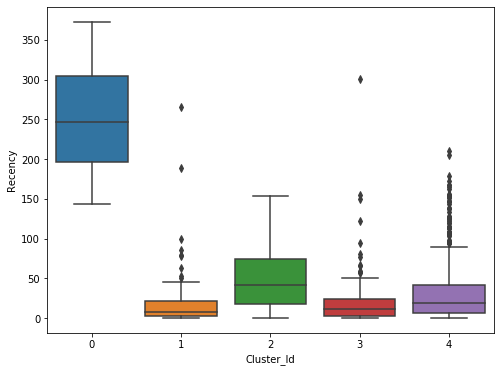

In [34]:
sns.boxplot(x='Cluster_Id', y='Recency', data=mergedDateFrame)

# RESULTS

We can conclude from the following that K-Means Clustering result where five Cluster Ids is used, and that customers with Cluster Id “1” have a higher amount of transactions than other customers. Customers with Cluster Id “3” are frequent purchasers. Customers with Cluster Id “0” are not recent buyers and, as a result, are not as important to the business as customer with clusters. So, it is more profitable to focus on customer who does not fall under Cluster Id “1” and can be targeted for future new product promotion.

# Hierarchical Clustering Implementation


# Single Linkage for Hierarchical Clustering

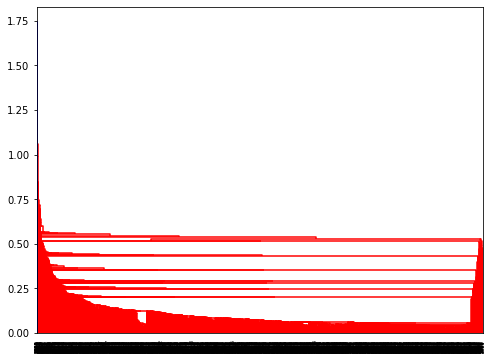

Wall time: 1min 11s


In [35]:
%%time
SL_mergings = linkage(merged_DateFrame_scaled, method="single", metric='euclidean')
dendrogram(SL_mergings)
plt.show()

In [114]:
# Silhouette analysis for single linkage Clustering
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_cluster in range_n_clusters: 

    cluster_single = AgglomerativeClustering(n_clusters=num_cluster, affinity='euclidean',linkage='single')

    cluster_single.fit_predict(merged_DateFrame_scaled)
    merged_DateFrame_scaled["Cluster"] = cluster_single.labels_

    silhouette_avg = silhouette_score(merged_DateFrame_scaled, merged_DateFrame_scaled["Cluster"])
    print("Silhouette score is", format(silhouette_avg))


Silhouette score is 0.30476262096644424
Silhouette score is 0.4521355438549282
Silhouette score is 0.4874644063065225
Silhouette score is 0.48772283691388535
Silhouette score is 0.5310586265742421
Silhouette score is 0.4668069802878872
Silhouette score is 0.4610177919152861


# Complete Linkage for Hierarchical Clustering


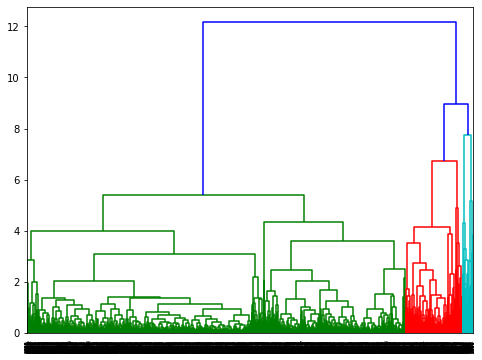

Wall time: 1min 11s


In [36]:
%%time
CL_mergings = linkage(merged_DateFrame_scaled, method="complete", metric='euclidean')
dendrogram(CL_mergings)
plt.show()

In [113]:
# Silhouette analysis for Complete linkage Clustering
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_cluster in range_n_clusters: 

    cluster_complete = AgglomerativeClustering(n_clusters=num_cluster, affinity='euclidean',linkage='complete')

    cluster_complete.fit_predict(merged_DateFrame_scaled)
    merged_DateFrame_scaled["Cluster"] = cluster_complete.labels_

    silhouette_avg = silhouette_score(merged_DateFrame_scaled, merged_DateFrame_scaled["Cluster"])
    print("Silhouette score is", format(silhouette_avg))



Silhouette score is 0.6443060097862378
Silhouette score is 0.47476138657702704
Silhouette score is 0.5763233906074967
Silhouette score is 0.594551524313311
Silhouette score is 0.5961072522396015
Silhouette score is 0.6374789453126763
Silhouette score is 0.607062308493869


# Average Linkage for Hierarchical Clustering

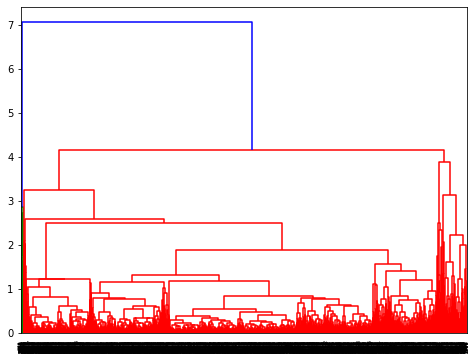

Wall time: 1min 12s


In [37]:
%%time
AL_mergings = linkage(merged_DateFrame_scaled, method="average", metric='euclidean')
dendrogram(AL_mergings)
plt.show()

In [117]:
# Silhouette analysis for average linkage Clustering
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_cluster in range_n_clusters: 

    cluster_average = AgglomerativeClustering(n_clusters=num_cluster, affinity='euclidean',linkage='average')

    cluster_average.fit_predict(merged_DateFrame_scaled)
    merged_DateFrame_scaled["Cluster"] = cluster_average.labels_

    silhouette_avg = silhouette_score(merged_DateFrame_scaled, merged_DateFrame_scaled["Cluster"])
    print("Silhouette score is", format(silhouette_avg))


Silhouette score is 0.48713001858049176
Silhouette score is 0.6045107242659497
Silhouette score is 0.6279246321380272
Silhouette score is 0.5370208515413372
Silhouette score is 0.574631869376242
Silhouette score is 0.6120240089241442
Silhouette score is 0.709074923494752


# Hierarchical Clustering with 3 Clusters

In [41]:
%%time
Cluster_Number = cut_tree(AL_mergings, n_clusters=3).reshape(-1, )
Cluster_Number

Wall time: 378 ms


array([0, 0, 0, ..., 0, 0, 0])

In [42]:
%%time
mergedDateFrame['Cluster_Number'] = Cluster_Number
mergedDateFrame.head()

Wall time: 1.03 ms


,CustomerID,Monetary,Frequency,Recency,Cluster_Id,Cluster_Labels,Cluster_Number
0,12346.0,0.00,2,325,0,0,0
1,12347.0,4310.00,182,1,4,0,0
2,12348.0,1797.24,31,74,2,0,0
3,12349.0,1757.55,73,18,2,0,0
4,12350.0,334.40,17,309,0,0,0


# Using Box Plot to visualise the plot of Monetary vs Cluster_Number

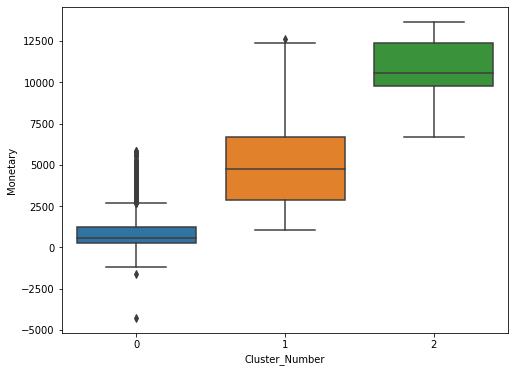

In [44]:
sns.boxplot(x='Cluster_Number', y='Monetary', data=mergedDateFrame)

# Using Box Plot to visualise the plot of Frequency vs Cluster_Number

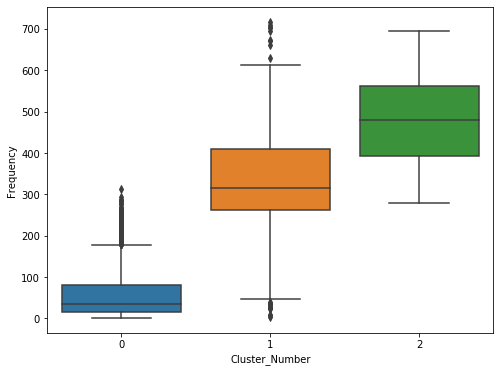

In [45]:
sns.boxplot(x='Cluster_Number', y='Frequency', data=mergedDateFrame)

# Using Box Plot to visualise the plot of Recency vs Cluster_Number

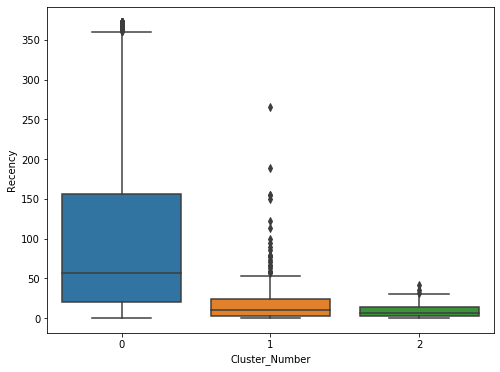

In [46]:
sns.boxplot(x='Cluster_Number', y='Recency', data=mergedDateFrame)

# RESULTS

In this part Hierarchical Clustering was used to segment the customer based on RFM(Recency, Frequency, Monetary), which helped to identify the most significant customers for the store and who could be targeted for future products. This will assist the store in increasing sales. In this Hierarchical Clustering, a total of three cluster labels were used. The following are the outcomes.

•	Customers in cluster label "2" have made the most transactions and spent the most money. Customers who fall into this category are the most valuable to the store since they can be targeted for future promotions and products. We can save time and money by focusing on the most important customers.

•	Customers in cluster label "2" are the most frequent buyers and come into the store the most frequently.

•	Customers with the cluster label "0" aren't recent consumers and so aren't as essential to the company as others. It will not result in a loss if we do not target them for future products and promotions.


# DBSCAN Clustering


In [62]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Implementation of DBSCAN

In [75]:
%%time
# create an object
dbscan = DBSCAN(eps=0.8, min_samples=7, metric='euclidean')

# fit the model
dbscan.fit(merged_DateFrame_scaled)

Wall time: 227 ms


DBSCAN(algorithm='auto', eps=0.8, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=7, n_jobs=None, p=None)

# Silhouette Score Analysis

In [76]:
from sklearn.metrics import silhouette_score

dbscan_label = dbscan.labels_   

# silhouette score
silhouette_avg = silhouette_score(merged_DateFrame_scaled, dbscan_label)
print("Silhouette score is", format(silhouette_avg))

Silhouette score is 0.6949788314743802


In [ ]:
# Silhouette analysis
min_points = [7, 6, 5, 4,3 ]

for min_po in min_points: 

     # create an object
    dbscan = DBSCAN(eps=0.8, min_samples=min_po, metric='euclidean')

    # fit the model
    dbscan.fit(merged_DateFrame_scaled)

    dbscan_label = dbscan.labels_
    silhouette_avg = silhouette_score(merged_DateFrame_scaled, dbscan_label)
    print("Silhouette score is", format(silhouette_avg))


# Labeling Clusters

In [61]:
merged_DateFrame_scaled['cluster_label']=mergedDateFrame.labels_

merged_DateFrame_scaled.head()

,Monetary,Frequency,Recency,cluster_label
0,-0.723738,-0.752888,2.301611,0
1,1.731617,1.042467,-0.906466,0
2,0.300128,-0.463636,-0.183658,0
3,0.277517,-0.044720,-0.738141,0
4,-0.533235,-0.603275,2.143188,0


# Using Box Plot to visualise the plot of Monetary vs Cluster_Number ,Frequency vs Cluster_Number and Recency vs Cluster_Number

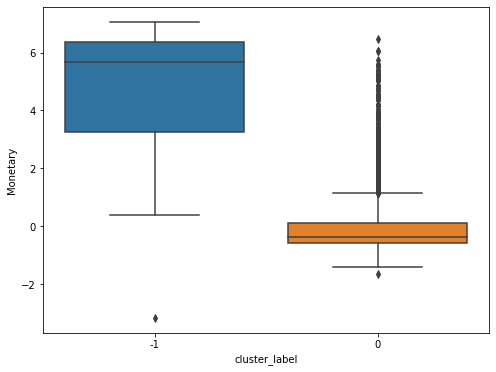

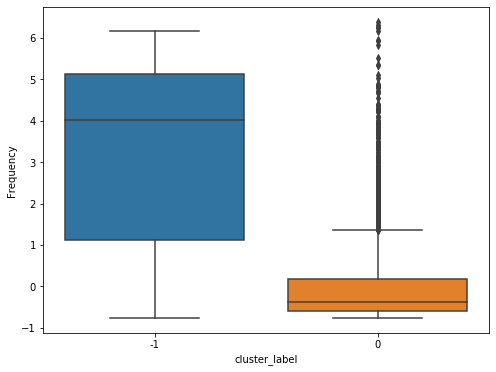

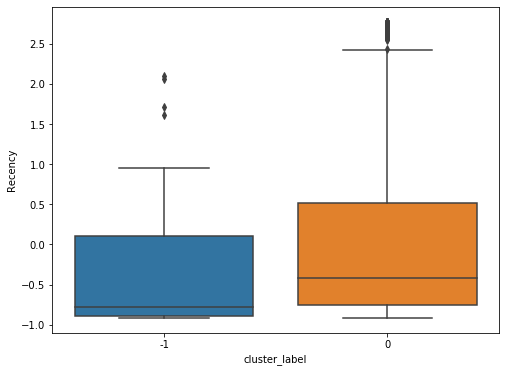

In [65]:
for c in merged_DateFrame_scaled.columns[:-1]:
    plt.figure(figsize=(8,6))
    sns.boxplot(data=merged_DateFrame_scaled, y=c, x='cluster_label')

    plt.show()

# RESULTS

#DBSCAN (Density-based spatial clustering of applications with noise) clustering was used to segment the customer based on RFM(Recency, Frequency, Monetary), which helped to identify the most significant customers for the store and who could be targeted for future products. This will assist the store in increasing sales. The following are the outcomes.

•	The customer who falls in cluster label "0 " is not a recent buyer, and hence is less important to our company than the rest.

•	The customer who falls in cluster label "-1 " are the customer who has the highest frequency of visiting the store.

•	Customers with the cluster label "-1" have made the most retail purchases and spent the most money. These are the most important customers for the store. For future promotions and new items, this consumer should be targeted.
